In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import helper_functions as hf

1. Load & process data

In [2]:
df = pd.read_csv("Input/in_silico_dataset.csv")

input_list = []
output_list = []

N_x = 201
N_D = 20

for idx, row in df.iterrows():
    # Inputs
    dV_ges = float(row["dV_ges"]) / 3.6 * 1e-6
    eps_0 = float(row["eps_0"])
    phi_0 = float(row["phi_0"])
    x_arr = np.array([float(v) for v in row["x"].split(",")])                # shape (N_x,)
    # Outputs
    V_dis_arr = np.array([float(v) for v in row["V_dis"].split(",")])        # (N_x,)
    V_c_arr   = np.array([float(v) for v in row["V_c"].split(",")])          # (N_x,)
    phi32_arr = np.array([float(v) for v in row["phi_32"].split(",")])       # (N_x,)
    N_arrs    = [np.array([float(v) for v in row[f"N_{j}"].split(",")]) for j in range(N_D)]  # list of (N_x,)

    for i in range(N_x):
        inp = [dV_ges, eps_0, phi_0, x_arr[i]]
        out = [V_dis_arr[i], V_c_arr[i], phi32_arr[i]] + [N_arrs[j][i] for j in range(N_D)]  # total 23 outputs
        input_list.append(inp)
        output_list.append(out)

X = np.array(input_list, dtype=np.float32)
Y = np.array(output_list, dtype=np.float32)
Y = np.maximum(Y, 0)  # Set negative values to 0

print("X shape:", X.shape)  # (100*N_x, 4)
print("Y shape:", Y.shape)  # (100*N_x, 23)

# --- Remove all-zero output columns automatically ---
col_nonzero = np.any(Y != 0, axis=0)
Y = Y[:, col_nonzero]
print("Kept output columns:", np.where(col_nonzero)[0])  # Save mapping for later

# Min-max normalization for inputs
X_min, X_max = X.min(axis=0), X.max(axis=0)
X_norm = (X - X_min) / (X_max - X_min + 1e-8)

# Min-max normalization for outputs
Y_min, Y_max = Y.min(axis=0), Y.max(axis=0)
Y_norm = (Y - Y_min) / (Y_max - Y_min + 1e-8)

print("X_norm shape:", X_norm.shape)
print("Y_norm shape:", Y_norm.shape)

X shape: (20100, 4)
Y shape: (20100, 23)
Kept output columns: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
X_norm shape: (20100, 4)
Y_norm shape: (20100, 22)


2. Create Torch Dataset and DNN model

In [3]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
class DNN(nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            self.net.add_module(f"layer{i}", nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.net.add_module(f"tanh{i}", nn.Tanh())
            else:
                self.net.add_module("sigmoid", nn.Sigmoid())

    def forward(self, x):
        return self.net(x)

3. Initiallize and train the model

In [6]:
# dataset = MyDataset(X_norm, Y_norm)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# layers = [X_norm.shape[1], 128, 128, 128, Y_norm.shape[1]]
# model = DNN(layers)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# loss_data = nn.MSELoss()

optimizer.param_groups[0]['lr'] = 1e-5

epochs = 100
for epoch in range(epochs):
    total_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = loss_data(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    print(f"Epoch {epoch+1:05d}/{epochs:05d}, Loss: {total_loss/len(dataset):.6e}")

Epoch 00001/00100, Loss: 3.150492e-06
Epoch 00002/00100, Loss: 3.092262e-06
Epoch 00003/00100, Loss: 3.086823e-06
Epoch 00004/00100, Loss: 3.085345e-06
Epoch 00005/00100, Loss: 3.081947e-06
Epoch 00006/00100, Loss: 3.071039e-06
Epoch 00007/00100, Loss: 3.074039e-06
Epoch 00008/00100, Loss: 3.080052e-06
Epoch 00009/00100, Loss: 3.075194e-06
Epoch 00010/00100, Loss: 3.091195e-06
Epoch 00011/00100, Loss: 3.084711e-06
Epoch 00012/00100, Loss: 3.066691e-06
Epoch 00013/00100, Loss: 3.064498e-06
Epoch 00014/00100, Loss: 3.062504e-06
Epoch 00015/00100, Loss: 3.074548e-06
Epoch 00016/00100, Loss: 3.062199e-06
Epoch 00017/00100, Loss: 3.067929e-06
Epoch 00018/00100, Loss: 3.062843e-06
Epoch 00019/00100, Loss: 3.059548e-06
Epoch 00020/00100, Loss: 3.056084e-06
Epoch 00021/00100, Loss: 3.045055e-06
Epoch 00022/00100, Loss: 3.062372e-06
Epoch 00023/00100, Loss: 3.054877e-06
Epoch 00024/00100, Loss: 3.032684e-06
Epoch 00025/00100, Loss: 3.073844e-06
Epoch 00026/00100, Loss: 3.048399e-06
Epoch 00027/

4. Postprocessing

C:\Users\Asus\AppData\Local\Temp\ipykernel_14664\1257958508.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pt"))


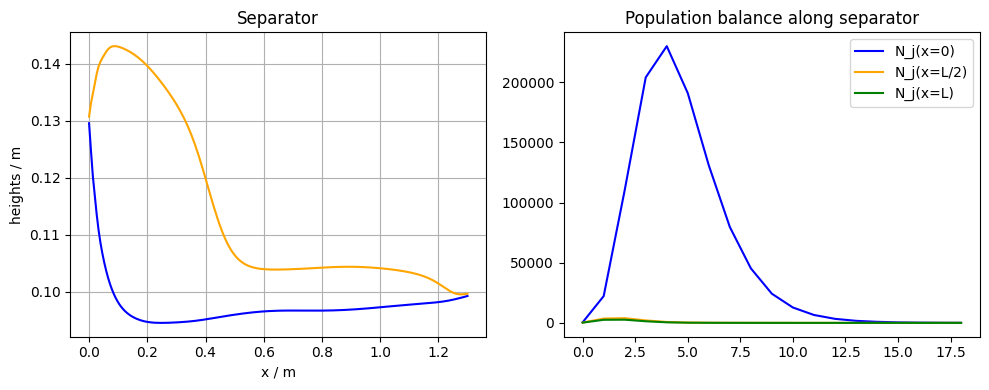

In [ ]:
### Example fixed inputs:

dV_ges_dim = 500
eps_0_dim  = 0.3
phi_0_dim  = 0.0005
x_dim      = np.linspace(0, 1.3, 201)  # shape (201,)
# x_dim      = 1.0


### Load model if needed

# torch.save(model.state_dict(), "model.pt")
# print("Model weights saved!")

layers = [X_norm.shape[1], 128, 128, 128, Y_norm.shape[1]]
model = DNN(layers)
model.load_state_dict(torch.load("model.pt"))




### evaluate model

result = hf.model_prediction(model, dV_ges_dim, eps_0_dim, phi_0_dim, x_dim, X_min, X_max, Y_min, Y_max, col_nonzero)



### Plot results

dl = x_dim[1] - x_dim[0]
h_c = hf.getHeightArray(result['V_c']/dl, 0.1)
h_c_dis = hf.getHeightArray((result['V_dis']+result['V_c'])/dl, 0.1)
N_j_ini = [result[f"N_{j}"][0] for j in range(1, N_D)]
N_j_mid = [result[f"N_{j}"][100] for j in range(1, N_D)]
N_j_end = [result[f"N_{j}"][-1] for j in range(1, N_D)]


fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot
axes[0].plot(x_dim, h_c, color='blue')
axes[0].plot(x_dim, h_c_dis, color='orange')
axes[0].set_title('Separator')
axes[0].set_xlabel('x / m')
axes[0].set_ylabel('heights / m')
axes[0].grid()

# Right subplot
axes[1].plot(N_j_ini, color='b', label='N_j(x=0)')
axes[1].plot(N_j_mid, color='orange', label='N_j(x=L/2)')
axes[1].plot(N_j_end, color='g', label='N_j(x=L)')
axes[1].set_title('Population balance along separator')
axes[1].legend()

plt.tight_layout()
plt.show()